In [191]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LogisticRegression
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# **Pengumpulan Data**



Dataset ini berisi mengenai Indeks Standar Pencemar Udara (ISPU) yang diukur dari 5 stasiun pemantau kualitas udara (SPKU) yang ada di Provinsi DKI Jakarta Tahun 2021

Penjelasan variabel dari data diatas sebagai berikut :

    tanggal : Tanggal pengukuran kualitas udara
    stasiun : Lokasi pengukuran di stasiun
    pm10 : Partikulat salah satu parameter yang diukur
    pm2,5 : Partikulat salah satu parameter yang diukur
    so2 : Sulfida (dalam bentuk SO2) salah satu parameter yang diukur
    co : Carbon Monoksida salah satu parameter yand diukur
    o3 : Ozon salah satu parameter yang diukur
    no2 : NItrogen dioksida salah satu parameter yang diukur
    max : Nilai ukur paling tinggi dari seluruh parameter yang diukur dalam waktu yang sama
    critical : Parameter yang hasil pengukurannya paling tinggi
    categori : Kategori hasil perhitungan indeks standar pencemaran udara



In [193]:
df = pd.read_csv('drive/MyDrive/MSIB 5 DATA ANALYST/Project/indeks-standar-pencemar-udara-di-spku-bulan-januari-sampai-desember-tahun-2021.csv')
df.head()

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,1/1/2021,DKI1 (Bunderan HI),38,53,29,6,31,13,53,PM25,SEDANG
1,1/2/2021,DKI1 (Bunderan HI),27,46,27,7,47,7,47,O3,BAIK
2,1/3/2021,DKI1 (Bunderan HI),44,58,25,7,40,13,58,PM25,SEDANG
3,1/4/2021,DKI1 (Bunderan HI),30,48,24,4,32,7,48,PM25,BAIK
4,1/5/2021,DKI1 (Bunderan HI),38,53,24,6,31,9,53,PM25,SEDANG



**Informasi**

Berdasarkan Peraturan Menteri Lingkungan Hidup dan Kehutanan Republik Indonesia P.14/MENLHK/SETJEN/KUM.1/7/2020 tentang 'Indeks Standar Pencemar Udara (ISPU)' menunjukkan beberapa parameter sebagai berikut:

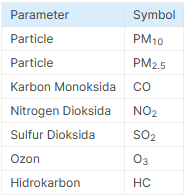

Polutan dapat dihuni dalam kisaran jumlah sebagai:

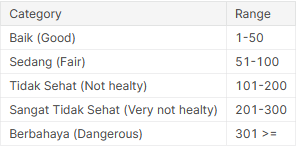

Ada kolom bernama pm25 seharusnya pm2.5, jadi kita bisa mengubahnya menjadi pm2.5

In [194]:
df = df.rename(columns={'pm25': 'pm2.5'})

In [195]:
df.head()

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,max,critical,categori
0,1/1/2021,DKI1 (Bunderan HI),38,53,29,6,31,13,53,PM25,SEDANG
1,1/2/2021,DKI1 (Bunderan HI),27,46,27,7,47,7,47,O3,BAIK
2,1/3/2021,DKI1 (Bunderan HI),44,58,25,7,40,13,58,PM25,SEDANG
3,1/4/2021,DKI1 (Bunderan HI),30,48,24,4,32,7,48,PM25,BAIK
4,1/5/2021,DKI1 (Bunderan HI),38,53,24,6,31,9,53,PM25,SEDANG


# **Pembersihan dan Prepocessing Data**

In [196]:
counts = df['categori'].value_counts()
print(counts)

SEDANG            1349
TIDAK SEHAT        272
BAIK               187
TIDAK ADA DATA      16
Name: categori, dtype: int64


In [197]:
# Mengganti nilai 'tidak ada data' dengan NaN
df['categori'] = df['categori'].replace('TIDAK ADA DATA', np.nan)

# Mengganti nilai NaN dengan modus dari kolom 'categori'
mode_value = df['categori'].mode()[0]
df['categori'] = df['categori'].fillna(mode_value)

# Menampilkan DataFrame setelah penggantian


In [198]:
counts = df['categori'].value_counts()
print(counts)

SEDANG         1366
TIDAK SEHAT     272
BAIK            187
Name: categori, dtype: int64


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tanggal   1825 non-null   object
 1   stasiun   1825 non-null   object
 2   pm10      1825 non-null   object
 3   pm2.5     1763 non-null   object
 4   so2       1825 non-null   object
 5   co        1825 non-null   object
 6   o3        1825 non-null   object
 7   no2       1825 non-null   object
 8   max       1825 non-null   object
 9   critical  1809 non-null   object
 10  categori  1825 non-null   object
dtypes: object(11)
memory usage: 157.0+ KB


In [200]:
counts = df['categori'].value_counts()
print(counts)

SEDANG         1366
TIDAK SEHAT     272
BAIK            187
Name: categori, dtype: int64


In [201]:
df.isna().sum()

tanggal      0
stasiun      0
pm10         0
pm2.5       62
so2          0
co           0
o3           0
no2          0
max          0
critical    16
categori     0
dtype: int64

In [202]:
counts = df['critical'].value_counts()
print(counts)

PM25    1630
PM10      63
O3        56
CO        34
SO2       25
BAIK       1
Name: critical, dtype: int64


In [203]:
counts = df['max'].value_counts()
print(counts)

77     52
81     44
80     39
79     38
71     37
       ..
161     1
141     1
128     1
151     1
136     1
Name: max, Length: 129, dtype: int64


In [204]:
df = df.drop(df.columns[[8, 9]], axis=1)
df.head()

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,categori
0,1/1/2021,DKI1 (Bunderan HI),38,53,29,6,31,13,SEDANG
1,1/2/2021,DKI1 (Bunderan HI),27,46,27,7,47,7,BAIK
2,1/3/2021,DKI1 (Bunderan HI),44,58,25,7,40,13,SEDANG
3,1/4/2021,DKI1 (Bunderan HI),30,48,24,4,32,7,BAIK
4,1/5/2021,DKI1 (Bunderan HI),38,53,24,6,31,9,SEDANG


In [205]:
# Simpan DataFrame sebelum konversi
df_before_conversion = df.copy()

**Transformasi Data**

In [206]:
labelencoder = LabelEncoder()
df['categori'] = labelencoder.fit_transform(df['categori'])
df['stasiun'] = labelencoder.fit_transform(df['stasiun'])

df

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,categori
0,1/1/2021,0,38,53,29,6,31,13,1
1,1/2/2021,0,27,46,27,7,47,7,0
2,1/3/2021,0,44,58,25,7,40,13,1
3,1/4/2021,0,30,48,24,4,32,7,0
4,1/5/2021,0,38,53,24,6,31,9,1
...,...,...,...,...,...,...,...,...,...
1820,12/27/2021,4,54,76,36,14,21,47,1
1821,12/28/2021,4,44,68,20,11,21,33,1
1822,12/29/2021,4,34,54,28,8,25,29,1
1823,12/30/2021,4,53,75,25,15,23,44,1


In [207]:
df = df.replace('---', np.nan)

In [208]:
df

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,categori
0,1/1/2021,0,38,53,29,6,31,13,1
1,1/2/2021,0,27,46,27,7,47,7,0
2,1/3/2021,0,44,58,25,7,40,13,1
3,1/4/2021,0,30,48,24,4,32,7,0
4,1/5/2021,0,38,53,24,6,31,9,1
...,...,...,...,...,...,...,...,...,...
1820,12/27/2021,4,54,76,36,14,21,47,1
1821,12/28/2021,4,44,68,20,11,21,33,1
1822,12/29/2021,4,34,54,28,8,25,29,1
1823,12/30/2021,4,53,75,25,15,23,44,1


Memeriksa nilai yang hilang dan duplikasi

In [209]:
df.isnull().sum()

tanggal       0
stasiun       0
pm10         68
pm2.5       100
so2         114
co           36
o3           68
no2          35
categori      0
dtype: int64

In [210]:
df.isna().sum()

tanggal       0
stasiun       0
pm10         68
pm2.5       100
so2         114
co           36
o3           68
no2          35
categori      0
dtype: int64

In [211]:
df.duplicated().sum()

0

Isi nilai yang hilang dengan median

In [212]:
df = df.fillna(0)

In [213]:
median_kolom_1 = df['pm10'].median()
df['pm10'] = df['pm10'].replace(0, median_kolom_1)

median_kolom_2 = df['pm2.5'].median()
df['pm2.5'] = df['pm2.5'].replace(0, median_kolom_2)

median_kolom_3 = df['so2'].median()
df['so2'] = df['so2'].replace(0, median_kolom_3)

median_kolom_4 = df['co'].median()
df['co'] = df['co'].replace(0, median_kolom_4)

median_kolom_5 = df['o3'].median()
df['o3'] = df['o3'].replace(0, median_kolom_5)

median_kolom_6 = df['no2'].median()
df['no2'] = df['no2'].replace(0, median_kolom_6)

In [214]:
df.isnull().sum()

tanggal     0
stasiun     0
pm10        0
pm2.5       0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [215]:
df

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,categori
0,1/1/2021,0,38,53,29,6,31,13,1
1,1/2/2021,0,27,46,27,7,47,7,0
2,1/3/2021,0,44,58,25,7,40,13,1
3,1/4/2021,0,30,48,24,4,32,7,0
4,1/5/2021,0,38,53,24,6,31,9,1
...,...,...,...,...,...,...,...,...,...
1820,12/27/2021,4,54,76,36,14,21,47,1
1821,12/28/2021,4,44,68,20,11,21,33,1
1822,12/29/2021,4,34,54,28,8,25,29,1
1823,12/30/2021,4,53,75,25,15,23,44,1


**Mencari Variabel yang saling berhubungan menggunakan Corelation**

In [216]:
print (df.dtypes)

tanggal     object
stasiun      int64
pm10        object
pm2.5       object
so2         object
co          object
o3          object
no2         object
categori     int64
dtype: object


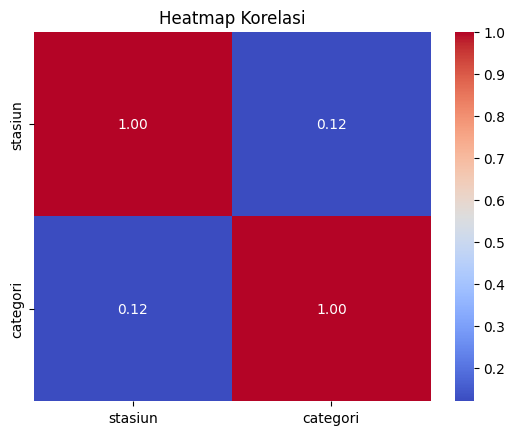

In [217]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()

# Menampilkan heatmap korelasi dengan Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi")
plt.show()

<Figure size 1200x600 with 0 Axes>

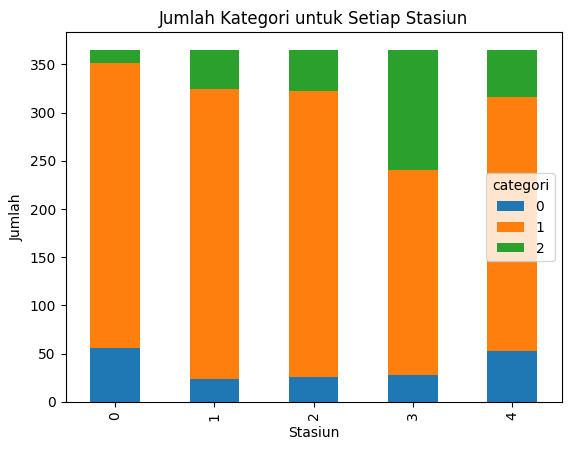

In [218]:
# Menghitung jumlah kategori untuk setiap stasiun
count_per_station = df.groupby('stasiun')['categori'].value_counts().unstack()

# Menggambar bar plot
plt.figure(figsize=(12, 6))
count_per_station.plot(kind='bar', stacked=True)
plt.title('Jumlah Kategori untuk Setiap Stasiun')
plt.xlabel('Stasiun')
plt.ylabel('Jumlah')
plt.show()

In [219]:
# Simpan encoder untuk kolom kategori
labelencoder_categori = LabelEncoder()

# Konversi kolom kategori
df['categori'] = labelencoder_categori.fit_transform(df['categori'])

# Menampilkan angka yang mewakili label kategori sebelum dan sesudah konversi
print("Angka yang Mewakili Label Kategori Sebelum Konversi:")
print(df_before_conversion['categori'].unique())

print("\nAngka yang Mewakili Label Kategori Sesudah Konversi:")
print(df['categori'].unique())

Angka yang Mewakili Label Kategori Sebelum Konversi:
['SEDANG' 'BAIK' 'TIDAK SEHAT']

Angka yang Mewakili Label Kategori Sesudah Konversi:
[1 0 2]


In [220]:
# Simpan encoder untuk kolom kategori
labelencoder_categori = LabelEncoder()

# Konversi kolom kategori
df['stasiun'] = labelencoder_categori.fit_transform(df['stasiun'])

# Menampilkan angka yang mewakili label kategori sebelum dan sesudah konversi
print("Angka yang Mewakili Label Kategori Sebelum Konversi:")
print(df_before_conversion['stasiun'].unique())

print("\nAngka yang Mewakili Label Kategori Sesudah Konversi:")
print(df['stasiun'].unique())

Angka yang Mewakili Label Kategori Sebelum Konversi:
['DKI1 (Bunderan HI)' 'DKI2 (Kelapa Gading)' 'DKI3 (Jagakarsa)'
 'DKI4 (Lubang Buaya)' 'DKI5 (Kebon Jeruk) Jakarta Barat']

Angka yang Mewakili Label Kategori Sesudah Konversi:
[0 1 2 3 4]


In [221]:
df

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,categori
0,1/1/2021,0,38,53,29,6,31,13,1
1,1/2/2021,0,27,46,27,7,47,7,0
2,1/3/2021,0,44,58,25,7,40,13,1
3,1/4/2021,0,30,48,24,4,32,7,0
4,1/5/2021,0,38,53,24,6,31,9,1
...,...,...,...,...,...,...,...,...,...
1820,12/27/2021,4,54,76,36,14,21,47,1
1821,12/28/2021,4,44,68,20,11,21,33,1
1822,12/29/2021,4,34,54,28,8,25,29,1
1823,12/30/2021,4,53,75,25,15,23,44,1


**Transformasi Data**

In [222]:
# Menggunakan df_before_conversion untuk mendapatkan nilai semula
df_before_conversion['categori_decoded'] = labelencoder.inverse_transform(df['categori'])

# Menampilkan DataFrame dengan nilai semula
print("\nDataFrame dengan nilai semula:")


DataFrame dengan nilai semula:


In [223]:
# Menghapus kolom 'categori_decoded' dari DataFrame
df_before_conversion = df_before_conversion.drop(columns=['categori_decoded'])

# Menampilkan DataFrame setelah menghapus kolom
print(df_before_conversion)

         tanggal                           stasiun pm10 pm2.5 so2  co  o3 no2  \
0       1/1/2021                DKI1 (Bunderan HI)   38    53  29   6  31  13   
1       1/2/2021                DKI1 (Bunderan HI)   27    46  27   7  47   7   
2       1/3/2021                DKI1 (Bunderan HI)   44    58  25   7  40  13   
3       1/4/2021                DKI1 (Bunderan HI)   30    48  24   4  32   7   
4       1/5/2021                DKI1 (Bunderan HI)   38    53  24   6  31   9   
...          ...                               ...  ...   ...  ..  ..  ..  ..   
1820  12/27/2021  DKI5 (Kebon Jeruk) Jakarta Barat   54    76  36  14  21  47   
1821  12/28/2021  DKI5 (Kebon Jeruk) Jakarta Barat   44    68  20  11  21  33   
1822  12/29/2021  DKI5 (Kebon Jeruk) Jakarta Barat   34    54  28   8  25  29   
1823  12/30/2021  DKI5 (Kebon Jeruk) Jakarta Barat   53    75  25  15  23  44   
1824  12/31/2021  DKI5 (Kebon Jeruk) Jakarta Barat   60    87  28  19  30  53   

     categori  
0      SEDA

In [224]:
# Membuat dictionary untuk mapping nama stasiun yang ingin diubah
nama_stasiun_mapping = {'DKI1 (Bunderan HI)': 'Jakarta Pusat', 'DKI2 (Kelapa Gading)': 'Jakarta Utara', 'DKI3 (Jagakarsa)' : 'Jakarta Selatan', 'DKI4 (Lubang Buaya)' : 'Jakarta Timur', 'DKI5 (Kebon Jeruk) Jakarta Barat' : 'Jakarta Barat'}

# Mengubah nama isi variabel 'stasiun' menggunakan metode replace
df_before_conversion['stasiun'] = df_before_conversion['stasiun'].replace(nama_stasiun_mapping)

# Tampilkan DataFrame setelah perubahan
df_before_conversion

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,categori
0,1/1/2021,Jakarta Pusat,38,53,29,6,31,13,SEDANG
1,1/2/2021,Jakarta Pusat,27,46,27,7,47,7,BAIK
2,1/3/2021,Jakarta Pusat,44,58,25,7,40,13,SEDANG
3,1/4/2021,Jakarta Pusat,30,48,24,4,32,7,BAIK
4,1/5/2021,Jakarta Pusat,38,53,24,6,31,9,SEDANG
...,...,...,...,...,...,...,...,...,...
1820,12/27/2021,Jakarta Barat,54,76,36,14,21,47,SEDANG
1821,12/28/2021,Jakarta Barat,44,68,20,11,21,33,SEDANG
1822,12/29/2021,Jakarta Barat,34,54,28,8,25,29,SEDANG
1823,12/30/2021,Jakarta Barat,53,75,25,15,23,44,SEDANG


In [225]:
# Membuat dictionary untuk mapping lokasi berdasarkan stasiun
lokasi_mapping = {'Jakarta Pusat' : 'Bundaran HI', 'Jakarta Utara' : 'Kelapa Gading', 'Jakarta Selatan': 'Jagakarsa', 'Jakarta Timur' : 'Lubang Buaya','Jakarta Barat' : 'Kebon Jeruk'}

# Menambahkan kolom 'lokasi' dan mengaitkannya dengan kolom 'stasiun'
df_before_conversion['lokasi'] = df_before_conversion['stasiun'].map(lokasi_mapping)

# Tampilkan DataFrame setelah penambahan kolom
df_before_conversion

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,categori,lokasi
0,1/1/2021,Jakarta Pusat,38,53,29,6,31,13,SEDANG,Bundaran HI
1,1/2/2021,Jakarta Pusat,27,46,27,7,47,7,BAIK,Bundaran HI
2,1/3/2021,Jakarta Pusat,44,58,25,7,40,13,SEDANG,Bundaran HI
3,1/4/2021,Jakarta Pusat,30,48,24,4,32,7,BAIK,Bundaran HI
4,1/5/2021,Jakarta Pusat,38,53,24,6,31,9,SEDANG,Bundaran HI
...,...,...,...,...,...,...,...,...,...,...
1820,12/27/2021,Jakarta Barat,54,76,36,14,21,47,SEDANG,Kebon Jeruk
1821,12/28/2021,Jakarta Barat,44,68,20,11,21,33,SEDANG,Kebon Jeruk
1822,12/29/2021,Jakarta Barat,34,54,28,8,25,29,SEDANG,Kebon Jeruk
1823,12/30/2021,Jakarta Barat,53,75,25,15,23,44,SEDANG,Kebon Jeruk


In [226]:
df_before_conversion = df_before_conversion.rename(columns={'stasiun': 'Kota'})
df_before_conversion = df_before_conversion.rename(columns={'lokasi': 'stasiun'})

In [227]:
df_before_conversion

,tanggal,Kota,pm10,pm2.5,so2,co,o3,no2,categori,stasiun
0,1/1/2021,Jakarta Pusat,38,53,29,6,31,13,SEDANG,Bundaran HI
1,1/2/2021,Jakarta Pusat,27,46,27,7,47,7,BAIK,Bundaran HI
2,1/3/2021,Jakarta Pusat,44,58,25,7,40,13,SEDANG,Bundaran HI
3,1/4/2021,Jakarta Pusat,30,48,24,4,32,7,BAIK,Bundaran HI
4,1/5/2021,Jakarta Pusat,38,53,24,6,31,9,SEDANG,Bundaran HI
...,...,...,...,...,...,...,...,...,...,...
1820,12/27/2021,Jakarta Barat,54,76,36,14,21,47,SEDANG,Kebon Jeruk
1821,12/28/2021,Jakarta Barat,44,68,20,11,21,33,SEDANG,Kebon Jeruk
1822,12/29/2021,Jakarta Barat,34,54,28,8,25,29,SEDANG,Kebon Jeruk
1823,12/30/2021,Jakarta Barat,53,75,25,15,23,44,SEDANG,Kebon Jeruk


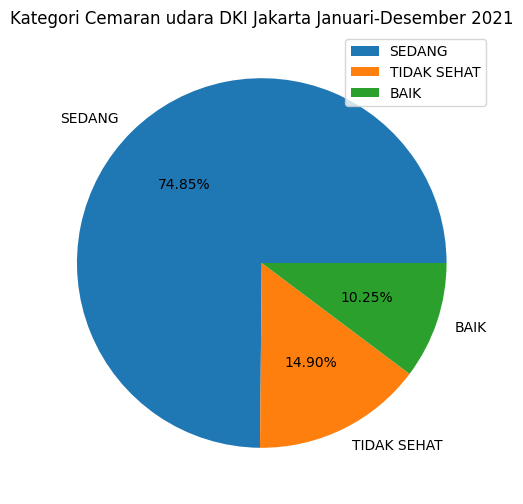

In [228]:
plt.figure(figsize=(8,6))

plt.pie(df_before_conversion.categori.value_counts(), labels=df_before_conversion.categori.value_counts().index, autopct='%.2f%%')

plt.title('Kategori Cemaran udara DKI Jakarta Januari-Desember 2021')
plt.legend()
plt.show()

In [229]:
df_before_conversion.Kota.unique()

array(['Jakarta Pusat', 'Jakarta Utara', 'Jakarta Selatan',
       'Jakarta Timur', 'Jakarta Barat'], dtype=object)

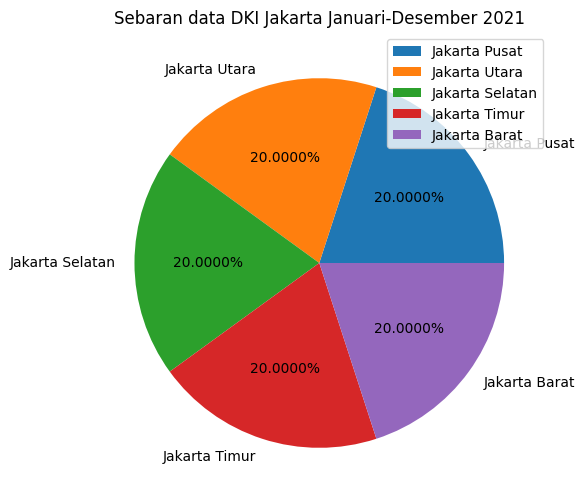

In [230]:
plt.figure(figsize=(8, 6))

# Ganti 'df' menjadi 'df_before_conversion' pada kedua tempat di bawah ini
plt.pie(df_before_conversion['Kota'].value_counts(), labels=df_before_conversion['Kota'].value_counts().index, autopct='%.4f%%')
plt.title('Sebaran data DKI Jakarta Januari-Desember 2021')
plt.legend()
plt.show()

In [231]:
# Simpan DataFrame sebelum konversi
df_before_conversion = df.copy()

# Simpan DataFrame ke file CSV
# df_before_conversion.to_csv('drive/MyDrive/MSIB 5 DATA ANALYST/Project/Dataset_ISPU_setelah_cleansing_ver2.csv', index=False)

# **Pembagian Data**

In [232]:
# Pembagian data menjadi data latih (train) dan data uji (test)
# test_size=0.2 artinya 20% dari data akan digunakan untuk uji, dan 80% untuk latih
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Menampilkan hasil pembagian data
print("Data Latih:")
print(train_data)

print("\nData Uji:")
print(test_data)

Data Latih:
        tanggal  stasiun  pm10 pm2.5 so2  co  o3 no2  categori
859   6/15/2021        3    67   111  42  13  22  25         2
1022  7/25/2021        3    81   148  38  22  28  24         2
170   2/16/2021        0    26    28  18  11  18  26         0
292   2/26/2021        4    24    49  21   7  22  18         0
1146  8/25/2021        2    57    81  44  10  33  11         1
...         ...      ...   ...   ...  ..  ..  ..  ..       ...
1130   8/9/2021        2    53    69  45   7  25  10         1
1294  9/20/2021        2    45    59  49   7  33  10         1
860   6/16/2021        3    62    88  35  20  19  22         1
1459  10/2/2021        3  53.0   127  46  10  35  19         2
1126   8/5/2021        2    52    82  51  11  23  15         1

[1460 rows x 9 columns]

Data Uji:
         tanggal  stasiun pm10 pm2.5   so2  co  o3 no2  categori
555    4/16/2021        3   61    90    42  17  21  20         1
1744  12/13/2021        2   53    68    44  11  23  10         1
2

# **Pemilihan Model -> Pelatihan -> Validasi -> Evaluasi -> Implementasi**

# **Model Regresi Logistic**

In [233]:
# Mengonversi kolom 'tanggal' ke tipe data datetime.
df['tanggal'] = pd.to_datetime(df['tanggal'])

# Menggunakan LabelEncoder untuk mengubah kategori stasiun menjadi nilai numerik.
le = LabelEncoder()
df['stasiun_encoded'] = le.fit_transform(df['stasiun'])

# Menambahkan fitur tahun dan bulan dari kolom 'tanggal' untuk mungkin digunakan sebagai fitur.
df['tahun'] = df['tanggal'].dt.year
df['bulan'] = df['tanggal'].dt.month

In [234]:
df

,tanggal,stasiun,pm10,pm2.5,so2,co,o3,no2,categori,stasiun_encoded,tahun,bulan
0,2021-01-01,0,38,53,29,6,31,13,1,0,2021,1
1,2021-01-02,0,27,46,27,7,47,7,0,0,2021,1
2,2021-01-03,0,44,58,25,7,40,13,1,0,2021,1
3,2021-01-04,0,30,48,24,4,32,7,0,0,2021,1
4,2021-01-05,0,38,53,24,6,31,9,1,0,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1820,2021-12-27,4,54,76,36,14,21,47,1,4,2021,12
1821,2021-12-28,4,44,68,20,11,21,33,1,4,2021,12
1822,2021-12-29,4,34,54,28,8,25,29,1,4,2021,12
1823,2021-12-30,4,53,75,25,15,23,44,1,4,2021,12


In [235]:
# Pilih kolom-kolom yang akan digunakan sebagai fitur
features = ['pm10', 'pm2.5', 'so2', 'co', 'o3', 'no2']

# Variabel prediktor (X) dan target (y)
X = df[features]
y = df['categori']

In [236]:
# Memisahkan data menjadi set train dan test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [237]:
# Melakukan standarisasi fitur untuk memastikan nilai-nilai memiliki skala yang seragam.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [238]:
# Membuat model Logistic Regression dan melatihnya menggunakan data pelatihan.
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [239]:
# Melakukan prediksi pada data pengujian dan mengevaluasi performa model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9123287671232877


In [240]:
#  Mencetak koefisien model untuk memberikan interpretasi mengenai seberapa besar pengaruh setiap fitur terhadap hasil.
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_[0]})
print(coef_df)

  Feature  Coefficient
0    pm10    -1.734560
1   pm2.5    -2.959803
2     so2    -0.308645
3      co     0.046733
4      o3    -0.337020
5     no2    -0.570266


  Feature  Coefficient
0    pm10    -1.734560
1   pm2.5    -2.959803
2     so2    -0.308645
3      co     0.046733
4      o3    -0.337020
5     no2    -0.570266


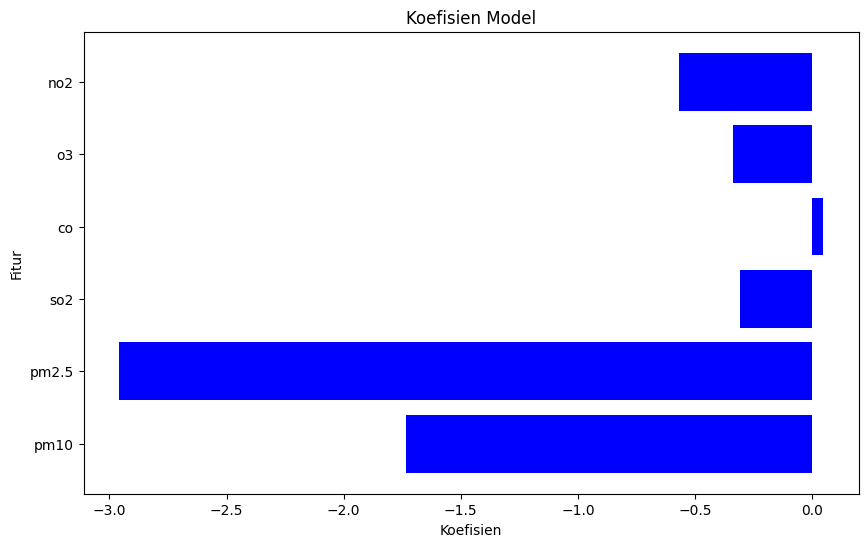

In [241]:
# Mencetak koefisien model untuk memberikan interpretasi mengenai
# seberapa besar pengaruh setiap fitur terhadap hasil.
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_[0]})
print(coef_df)

# Visualisasi koefisien dengan plot batang horizontal mengarah ke kanan
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='blue')
plt.xlabel('Koefisien')
plt.ylabel('Fitur')
plt.title('Koefisien Model')
plt.show()

# **Model Forecasting menggunakan FBProphet untuk prediksi**

In [242]:
# Ubah tipe data kolom 'tanggal' ke datetime
df['tanggal'] = pd.to_datetime(df['tanggal'])

# Ganti nama kolom 'tanggal' menjadi 'ds'
df = df.rename(columns={'tanggal': 'ds'})
df = df.rename(columns={'pm2.5': 'y'})

In [243]:
df

,ds,stasiun,pm10,y,so2,co,o3,no2,categori,stasiun_encoded,tahun,bulan
0,2021-01-01,0,38,53,29,6,31,13,1,0,2021,1
1,2021-01-02,0,27,46,27,7,47,7,0,0,2021,1
2,2021-01-03,0,44,58,25,7,40,13,1,0,2021,1
3,2021-01-04,0,30,48,24,4,32,7,0,0,2021,1
4,2021-01-05,0,38,53,24,6,31,9,1,0,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1820,2021-12-27,4,54,76,36,14,21,47,1,4,2021,12
1821,2021-12-28,4,44,68,20,11,21,33,1,4,2021,12
1822,2021-12-29,4,34,54,28,8,25,29,1,4,2021,12
1823,2021-12-30,4,53,75,25,15,23,44,1,4,2021,12


In [244]:
# Membuat objek baru prophet baru dan melakukan fitting terhadap dataset yang telah disimpan dalam df
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/ssp2svxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/zf8kwqc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9515', 'data', 'file=/tmp/tmp1lsysle3/ssp2svxr.json', 'init=/tmp/tmp1lsysle3/zf8kwqc0.json', 'output', 'file=/tmp/tmp1lsysle3/prophet_modelt_ltxzjg/prophet_model-20231203231314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [245]:
# Membuat kerangka dataframe untuk masa depan dengan periode 356 atau 1 tahun
# Menampilkan 5 baris terakhir
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
725,2022-12-27
726,2022-12-28
727,2022-12-29
728,2022-12-30
729,2022-12-31


In [246]:
# Melakukan prediksi terhadap variable future dan menambahkan kolom baru untuk data prediksi
# YHAT merupakan nilai prediksi
# YHAT_LOWER dan YHAT_UPPER adalah range error (kemungkinan data salah prediksi berada di interval tersebut)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
725,2022-12-27,-11.466030,-55.916350,34.263814
726,2022-12-28,-8.342606,-52.600586,40.256389
727,2022-12-29,-8.793056,-50.911799,38.277749
728,2022-12-30,-7.708836,-51.233481,40.187123
729,2022-12-31,-8.441831,-52.024441,38.051693


In [247]:
# Membuat plot hasil prediksi
# fig1 = m.plot(forecast)

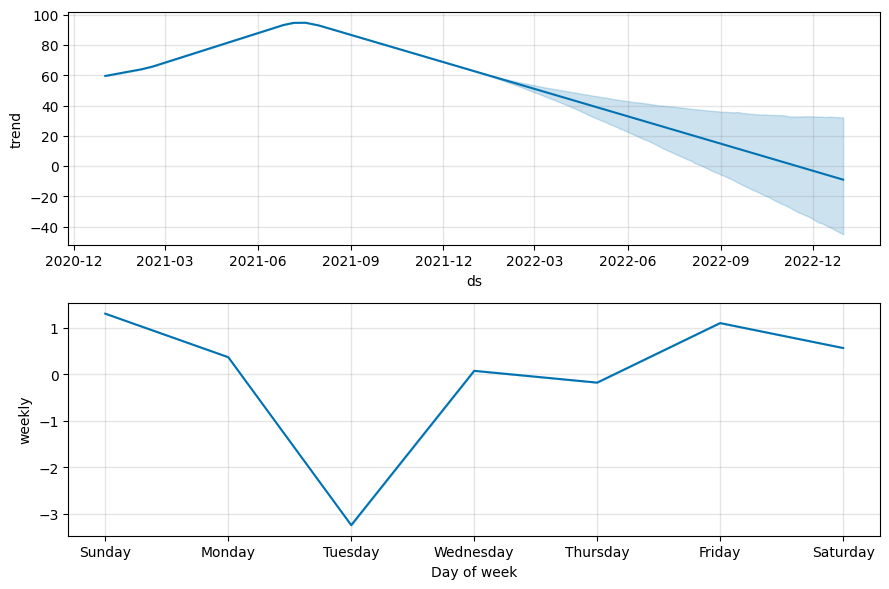

In [248]:
# Membuat plot dengan melihat trend dan weekly
fig2 = m.plot_components(forecast)

# **Model Forecasting menggunakan FBProphet untuk prediksi (Berdasarkan Wilayah)**

In [249]:
df = pd.read_csv('drive/MyDrive/MSIB 5 DATA ANALYST/Project/Dataset_ISPU_setelah_cleansing_ver2.csv')
df.head()

,tanggal,Kota,pm10,pm2.5,so2,co,o3,no2,max,critical,categori,stasiun
0,1/1/2021,Jakarta Pusat,38.0,53.0,29.0,6.0,31.0,13.0,53,PM25,SEDANG,Bundaran HI
1,1/2/2021,Jakarta Pusat,27.0,46.0,27.0,7.0,47.0,7.0,47,O3,BAIK,Bundaran HI
2,1/3/2021,Jakarta Pusat,44.0,58.0,25.0,7.0,40.0,13.0,58,PM25,SEDANG,Bundaran HI
3,1/4/2021,Jakarta Pusat,30.0,48.0,24.0,4.0,32.0,7.0,48,PM25,BAIK,Bundaran HI
4,1/5/2021,Jakarta Pusat,38.0,53.0,24.0,6.0,31.0,9.0,53,PM25,SEDANG,Bundaran HI


In [250]:
df = df.rename(columns={'tanggal': 'ds'})
df = df.rename(columns={'pm2.5': 'y'})

***Untuk Wilayah Jakarta Pusat***

In [251]:
values_to_remove = ['Kelapa Gading', 'Jagakarsa', 'Lubang Buaya', 'Kebon Jeruk']
df_DKI1 = df[~df['stasiun'].isin(values_to_remove)]

In [252]:
df_DKI1

,ds,Kota,pm10,y,so2,co,o3,no2,max,critical,categori,stasiun
0,1/1/2021,Jakarta Pusat,38.0,53.0,29.0,6.0,31.0,13.0,53,PM25,SEDANG,Bundaran HI
1,1/2/2021,Jakarta Pusat,27.0,46.0,27.0,7.0,47.0,7.0,47,O3,BAIK,Bundaran HI
2,1/3/2021,Jakarta Pusat,44.0,58.0,25.0,7.0,40.0,13.0,58,PM25,SEDANG,Bundaran HI
3,1/4/2021,Jakarta Pusat,30.0,48.0,24.0,4.0,32.0,7.0,48,PM25,BAIK,Bundaran HI
4,1/5/2021,Jakarta Pusat,38.0,53.0,24.0,6.0,31.0,9.0,53,PM25,SEDANG,Bundaran HI
...,...,...,...,...,...,...,...,...,...,...,...,...
1696,12/27/2021,Jakarta Pusat,52.0,71.0,61.0,15.0,20.0,15.0,71,PM25,SEDANG,Bundaran HI
1697,12/28/2021,Jakarta Pusat,51.0,65.0,53.0,15.0,18.0,13.0,65,PM25,SEDANG,Bundaran HI
1698,12/29/2021,Jakarta Pusat,31.0,49.0,54.0,10.0,24.0,11.0,54,SO2,SEDANG,Bundaran HI
1699,12/30/2021,Jakarta Pusat,55.0,71.0,53.0,16.0,23.0,14.0,71,PM25,SEDANG,Bundaran HI


In [253]:
# Membuat objek baru prophet baru dan melakukan fitting terhadap dataset yang telah disimpan dalam df
m = Prophet()
m.fit(df_DKI1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/5n_ff2rn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/z9r_d3gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61499', 'data', 'file=/tmp/tmp1lsysle3/5n_ff2rn.json', 'init=/tmp/tmp1lsysle3/z9r_d3gl.json', 'output', 'file=/tmp/tmp1lsysle3/prophet_modelwpj0m8ay/prophet_model-20231203231316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [254]:
# Membuat kerangka dataframe untuk masa depan dengan periode 356 atau 1 tahun
# Menampilkan 5 baris terakhir
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
450,2022-03-27
451,2022-03-28
452,2022-03-29
453,2022-03-30
454,2022-03-31


In [255]:
# Melakukan prediksi terhadap variable future dan menambahkan kolom baru untuk data prediksi
# YHAT merupakan nilai prediksi
# YHAT_LOWER dan YHAT_UPPER adalah range error (kemungkinan data salah prediksi berada di interval tersebut)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
450,2022-03-27,45.042315,25.550403,63.704276
451,2022-03-28,44.703619,25.341176,63.851474
452,2022-03-29,40.886249,19.862431,60.806118
453,2022-03-30,42.510068,24.848919,61.664685
454,2022-03-31,43.730285,24.467796,63.864277


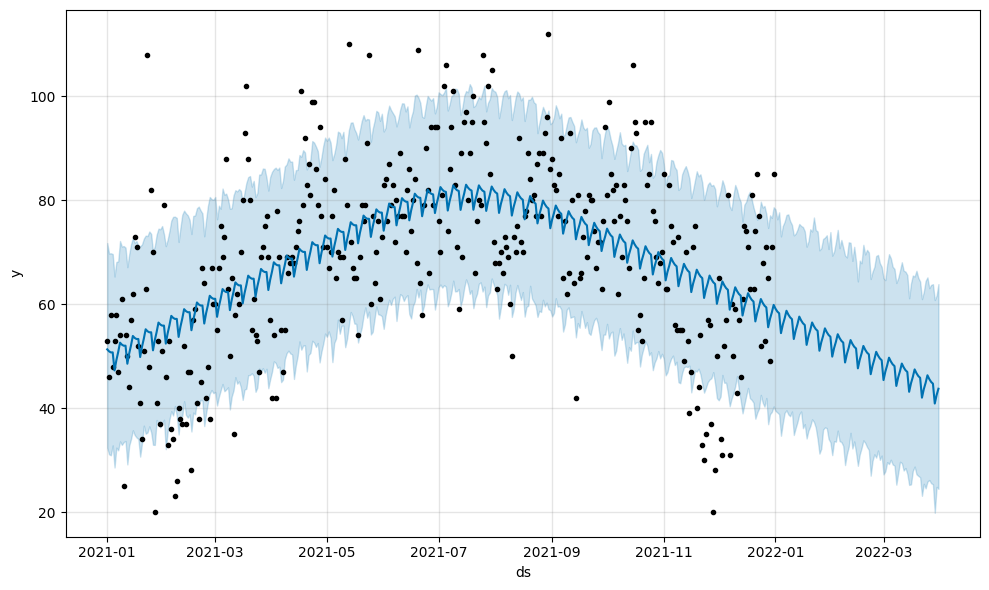

In [256]:
# Membuat plot hasil prediksi
fig1 = m.plot(forecast)

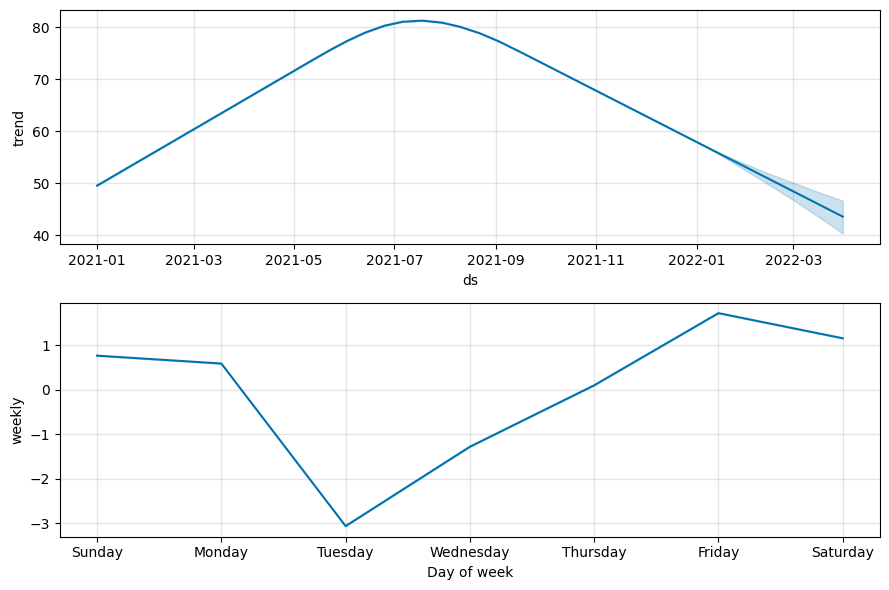

In [257]:
# Membuat plot dengan melihat trend dan weekly
fig2 = m.plot_components(forecast)

***Untuk Wilayah Jakarta Utara (Kelapa Gading)***

In [258]:
values_to_remove = ['Bundaran HI', 'Jagakarsa', 'Lubang Buaya', 'Kebon Jeruk']
df_DKI2 = df[~df['stasiun'].isin(values_to_remove)]

In [259]:
df_DKI2

,ds,Kota,pm10,y,so2,co,o3,no2,max,critical,categori,stasiun
31,1/1/2021,Jakarta Utara,38.0,58.0,2.0,11.0,65.0,6.0,65,O3,SEDANG,Kelapa Gading
32,1/2/2021,Jakarta Utara,29.0,46.0,33.0,12.0,80.0,12.0,80,O3,SEDANG,Kelapa Gading
33,1/3/2021,Jakarta Utara,37.0,59.0,33.0,10.0,86.0,13.0,86,O3,SEDANG,Kelapa Gading
34,1/4/2021,Jakarta Utara,30.0,49.0,33.0,9.0,77.0,7.0,77,O3,SEDANG,Kelapa Gading
35,1/5/2021,Jakarta Utara,35.0,52.0,33.0,8.0,77.0,7.0,77,O3,SEDANG,Kelapa Gading
...,...,...,...,...,...,...,...,...,...,...,...,...
1727,12/27/2021,Jakarta Utara,50.0,66.0,35.0,14.0,40.0,24.0,66,PM25,SEDANG,Kelapa Gading
1728,12/28/2021,Jakarta Utara,53.0,68.0,38.0,16.0,34.0,33.0,68,PM25,SEDANG,Kelapa Gading
1729,12/29/2021,Jakarta Utara,28.0,77.0,32.0,12.0,37.0,29.0,37,O3,BAIK,Kelapa Gading
1730,12/30/2021,Jakarta Utara,47.0,64.0,38.0,13.0,38.0,35.0,64,PM25,SEDANG,Kelapa Gading


In [260]:
# Membuat objek baru prophet baru dan melakukan fitting terhadap dataset yang telah disimpan dalam df
m = Prophet()
m.fit(df_DKI2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/7hhzn0oe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/nbb3zjfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31432', 'data', 'file=/tmp/tmp1lsysle3/7hhzn0oe.json', 'init=/tmp/tmp1lsysle3/nbb3zjfd.json', 'output', 'file=/tmp/tmp1lsysle3/prophet_modeltdk3tyfo/prophet_model-20231203231320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [261]:
# Membuat kerangka dataframe untuk masa depan dengan periode 356 atau 1 tahun
# Menampilkan 5 baris terakhir
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
450,2022-03-27
451,2022-03-28
452,2022-03-29
453,2022-03-30
454,2022-03-31


In [262]:
# Melakukan prediksi terhadap variable future dan menambahkan kolom baru untuk data prediksi
# YHAT merupakan nilai prediksi
# YHAT_LOWER dan YHAT_UPPER adalah range error (kemungkinan data salah prediksi berada di interval tersebut)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
450,2022-03-27,53.008021,34.073316,73.206415
451,2022-03-28,54.108391,33.720225,72.609711
452,2022-03-29,50.714641,31.113657,69.858738
453,2022-03-30,52.873851,33.671361,72.354809
454,2022-03-31,52.190627,31.896567,71.521573


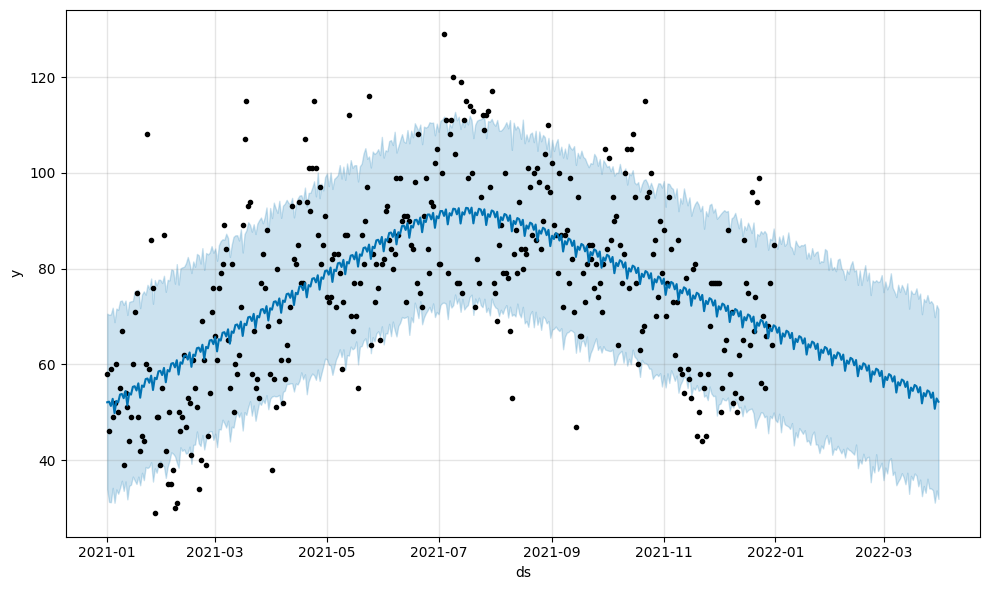

In [263]:
# Membuat plot hasil prediksi
fig1 = m.plot(forecast)

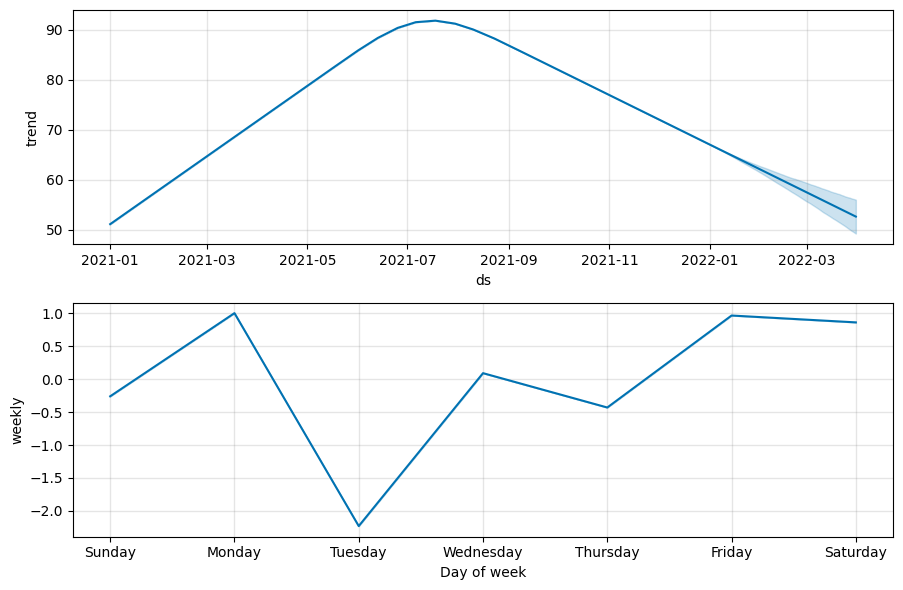

In [264]:
# Membuat plot dengan melihat trend dan weekly
fig2 = m.plot_components(forecast)

***Untuk Wilayah Jakarta Selatan (Jagakarsa)***

In [265]:
values_to_remove = ['Bundaran HI', 'Kelapa Gading', 'Lubang Buaya', 'Kebon Jeruk']
df_DKI3 = df[~df['stasiun'].isin(values_to_remove)]

In [266]:
df_DKI3

,ds,Kota,pm10,y,so2,co,o3,no2,max,critical,categori,stasiun
62,1/1/2021,Jakarta Selatan,43.0,56.0,15.0,10.0,33.0,5.0,56,PM25,SEDANG,Jagakarsa
63,1/2/2021,Jakarta Selatan,58.0,86.0,15.0,22.0,38.0,5.0,86,PM25,SEDANG,Jagakarsa
64,1/3/2021,Jakarta Selatan,64.0,93.0,14.0,20.0,35.0,5.0,93,PM25,SEDANG,Jagakarsa
65,1/4/2021,Jakarta Selatan,50.0,67.0,13.0,15.0,17.0,4.0,67,PM25,SEDANG,Jagakarsa
66,1/5/2021,Jakarta Selatan,59.0,89.0,15.0,19.0,42.0,7.0,89,PM25,SEDANG,Jagakarsa
...,...,...,...,...,...,...,...,...,...,...,...,...
1758,12/27/2021,Jakarta Selatan,75.0,116.0,35.0,23.0,38.0,21.0,116,PM25,TIDAK SEHAT,Jagakarsa
1759,12/28/2021,Jakarta Selatan,51.0,74.0,33.0,13.0,17.0,18.0,74,PM25,SEDANG,Jagakarsa
1760,12/29/2021,Jakarta Selatan,47.0,54.0,21.0,12.0,20.0,9.0,54,PM25,SEDANG,Jagakarsa
1761,12/30/2021,Jakarta Selatan,60.0,53.0,21.0,15.0,19.0,13.0,60,PM10,SEDANG,Jagakarsa


In [267]:
# Membuat objek baru prophet baru dan melakukan fitting terhadap dataset yang telah disimpan dalam df
m = Prophet()
m.fit(df_DKI3)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/ujsz8if8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/abeqh1cb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88610', 'data', 'file=/tmp/tmp1lsysle3/ujsz8if8.json', 'init=/tmp/tmp1lsysle3/abeqh1cb.json', 'output', 'file=/tmp/tmp1lsysle3/prophet_modelq1okh_vn/prophet_model-20231203231325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [268]:
# Membuat kerangka dataframe untuk masa depan dengan periode 356 atau 1 tahun
# Menampilkan 5 baris terakhir
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
450,2022-03-27
451,2022-03-28
452,2022-03-29
453,2022-03-30
454,2022-03-31


In [269]:
# Melakukan prediksi terhadap variable future dan menambahkan kolom baru untuk data prediksi
# YHAT merupakan nilai prediksi
# YHAT_LOWER dan YHAT_UPPER adalah range error (kemungkinan data salah prediksi berada di interval tersebut)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
450,2022-03-27,56.645693,28.273543,83.390724
451,2022-03-28,55.825863,29.513731,84.034150
452,2022-03-29,51.581418,24.474882,79.147492
453,2022-03-30,53.629244,25.861727,82.611670
454,2022-03-31,52.194739,25.225833,80.033590


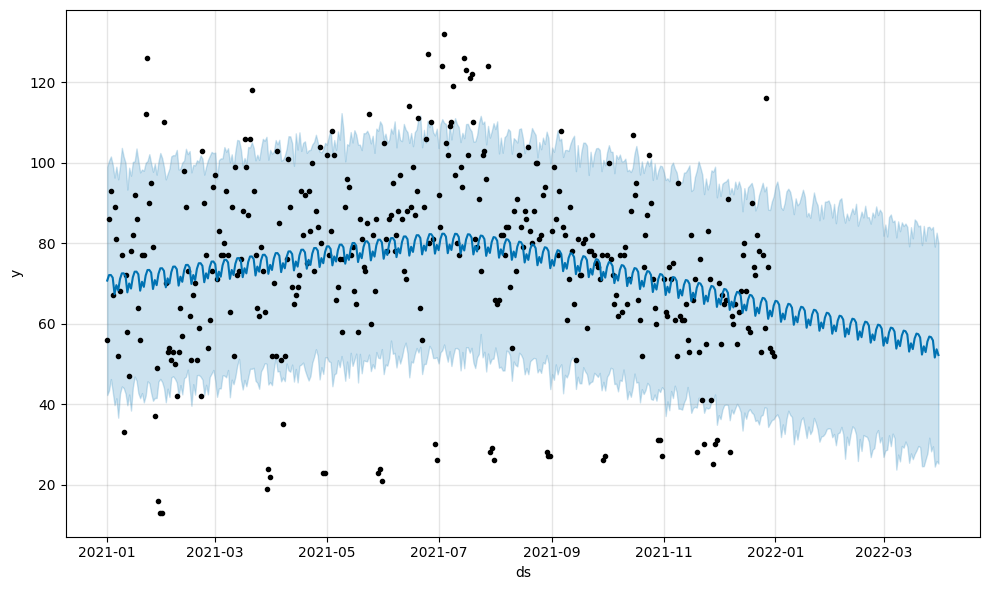

In [270]:
# Membuat plot hasil prediksi
fig1 = m.plot(forecast)

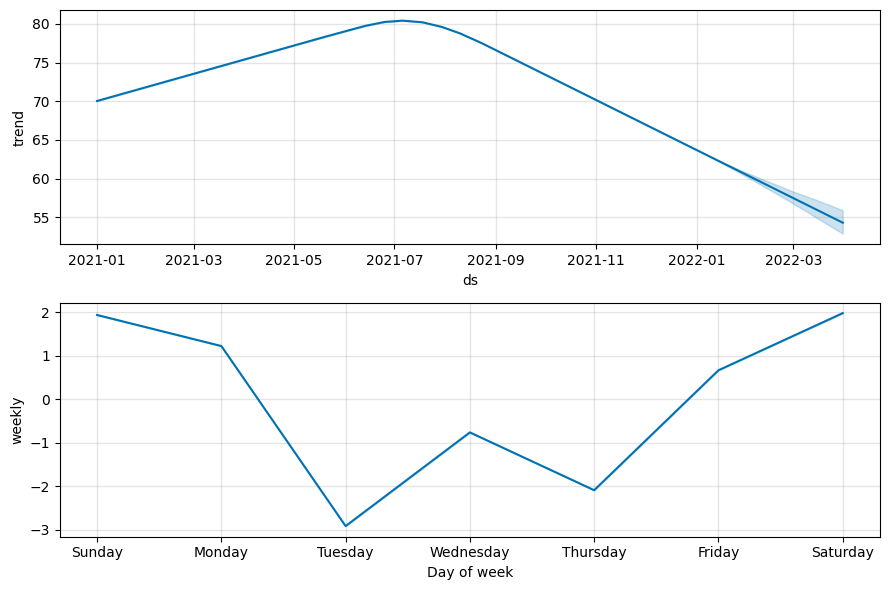

In [271]:
# Membuat plot dengan melihat trend dan weekly
fig2 = m.plot_components(forecast)

***Untuk Wilayah Jakarta Timur (Lubang Buaya)***

In [272]:
values_to_remove = ['Bundaran HI', 'Kelapa Gading', 'Jagakarsa', 'Kebon Jeruk']
df_DKI4 = df[~df['stasiun'].isin(values_to_remove)]

In [273]:
df_DKI4

,ds,Kota,pm10,y,so2,co,o3,no2,max,critical,categori,stasiun
93,1/1/2021,Jakarta Timur,41.0,77.0,37.0,14.0,35.0,4.0,41,PM10,BAIK,Lubang Buaya
94,1/2/2021,Jakarta Timur,44.0,77.0,38.0,38.0,59.0,3.0,59,CO,SEDANG,Lubang Buaya
95,1/3/2021,Jakarta Timur,50.0,77.0,37.0,16.0,52.0,5.0,52,CO,SEDANG,Lubang Buaya
96,1/4/2021,Jakarta Timur,45.0,77.0,36.0,16.0,24.0,3.0,45,PM10,BAIK,Lubang Buaya
97,1/5/2021,Jakarta Timur,52.0,77.0,36.0,15.0,35.0,8.0,52,PM10,SEDANG,Lubang Buaya
...,...,...,...,...,...,...,...,...,...,...,...,...
1789,12/27/2021,Jakarta Timur,68.0,121.0,17.0,21.0,28.0,12.0,121,PM25,TIDAK SEHAT,Lubang Buaya
1790,12/28/2021,Jakarta Timur,59.0,89.0,38.0,15.0,28.0,22.0,89,PM25,SEDANG,Lubang Buaya
1791,12/29/2021,Jakarta Timur,61.0,98.0,37.0,15.0,28.0,19.0,98,PM25,SEDANG,Lubang Buaya
1792,12/30/2021,Jakarta Timur,60.0,102.0,38.0,17.0,28.0,21.0,102,PM25,TIDAK SEHAT,Lubang Buaya


In [274]:
# Membuat objek baru prophet baru dan melakukan fitting terhadap dataset yang telah disimpan dalam df
m = Prophet()
m.fit(df_DKI4)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/_qxc8xcp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/rcgm0tsa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59736', 'data', 'file=/tmp/tmp1lsysle3/_qxc8xcp.json', 'init=/tmp/tmp1lsysle3/rcgm0tsa.json', 'output', 'file=/tmp/tmp1lsysle3/prophet_model9f5fynnp/prophet_model-20231203231329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [275]:
# Membuat kerangka dataframe untuk masa depan dengan periode 356 atau 1 tahun
# Menampilkan 5 baris terakhir
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
450,2022-03-27
451,2022-03-28
452,2022-03-29
453,2022-03-30
454,2022-03-31


In [276]:
# Melakukan prediksi terhadap variable future dan menambahkan kolom baru untuk data prediksi
# YHAT merupakan nilai prediksi
# YHAT_LOWER dan YHAT_UPPER adalah range error (kemungkinan data salah prediksi berada di interval tersebut)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
450,2022-03-27,61.459389,36.780690,85.236969
451,2022-03-28,57.224969,30.697502,82.241344
452,2022-03-29,54.086935,28.340249,79.980789
453,2022-03-30,60.300184,33.464772,86.892958
454,2022-03-31,58.434788,33.215096,86.148709


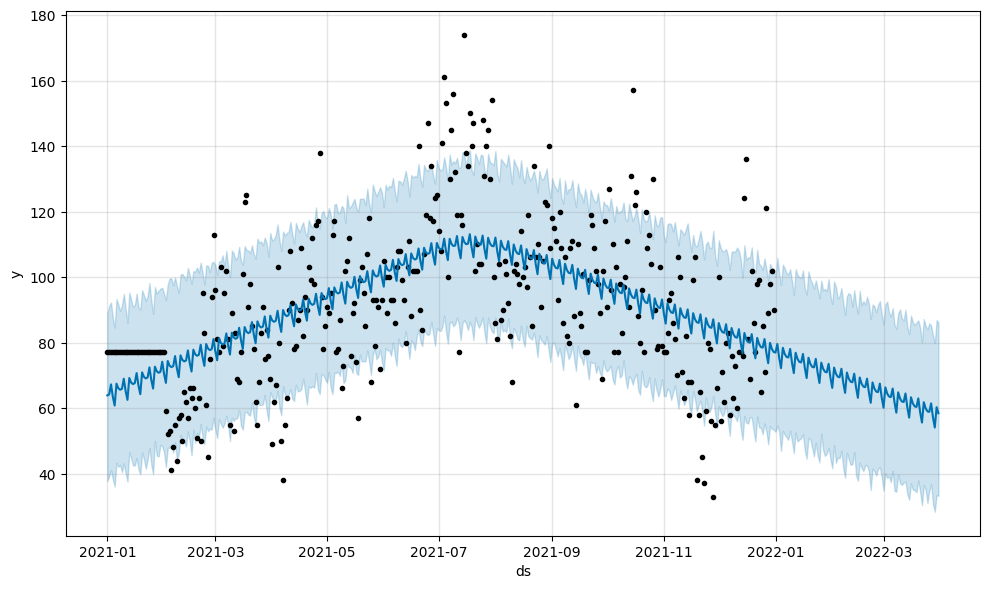

In [277]:
# Membuat plot hasil prediksi
fig1 = m.plot(forecast)

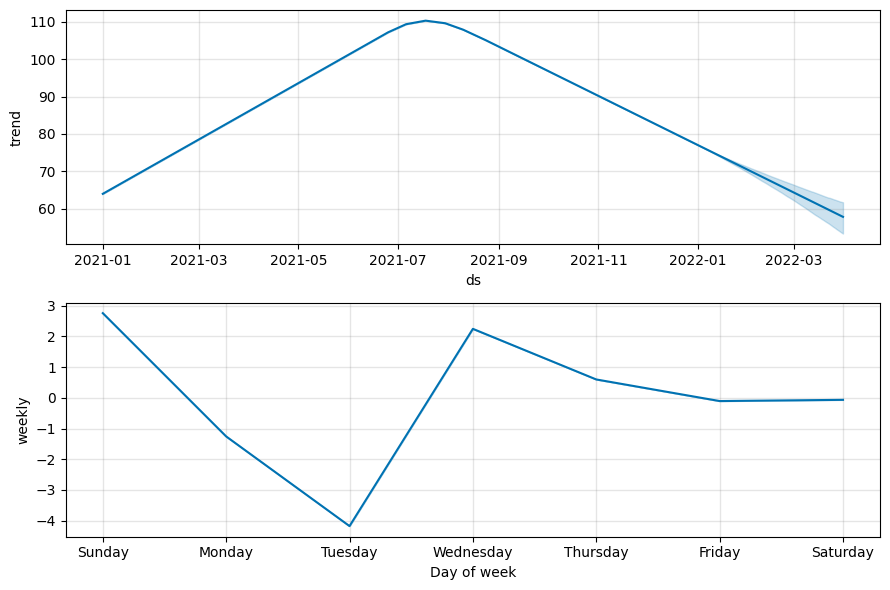

In [278]:
# Membuat plot dengan melihat trend dan weekly
fig2 = m.plot_components(forecast)

***Untuk Wilayah Jakarta Barat (Kebon Jeruk)***

In [279]:
values_to_remove = ['Bundaran HI', 'Kelapa Gading', 'Jagakarsa', 'Lubang Buaya']
df_DKI5 = df[~df['stasiun'].isin(values_to_remove)]

In [280]:
df_DKI5

,ds,Kota,pm10,y,so2,co,o3,no2,max,critical,categori,stasiun
124,1/1/2021,Jakarta Barat,37.0,77.0,20.0,12.0,25.0,4.0,37,PM10,BAIK,Kebon Jeruk
125,1/2/2021,Jakarta Barat,33.0,77.0,18.0,20.0,64.0,6.0,64,CO,SEDANG,Kebon Jeruk
126,1/3/2021,Jakarta Barat,42.0,77.0,15.0,10.0,62.0,3.0,62,CO,SEDANG,Kebon Jeruk
127,1/4/2021,Jakarta Barat,27.0,77.0,14.0,7.0,31.0,4.0,31,CO,BAIK,Kebon Jeruk
128,1/5/2021,Jakarta Barat,41.0,77.0,15.0,9.0,28.0,18.0,41,PM10,BAIK,Kebon Jeruk
...,...,...,...,...,...,...,...,...,...,...,...,...
1820,12/27/2021,Jakarta Barat,54.0,76.0,36.0,14.0,21.0,47.0,76,PM25,SEDANG,Kebon Jeruk
1821,12/28/2021,Jakarta Barat,44.0,68.0,20.0,11.0,21.0,33.0,68,PM25,SEDANG,Kebon Jeruk
1822,12/29/2021,Jakarta Barat,34.0,54.0,28.0,8.0,25.0,29.0,54,PM25,SEDANG,Kebon Jeruk
1823,12/30/2021,Jakarta Barat,53.0,75.0,25.0,15.0,23.0,44.0,75,PM25,SEDANG,Kebon Jeruk


In [281]:
# Membuat kerangka dataframe untuk masa depan dengan periode 356 atau 1 tahun
# Menampilkan 5 baris terakhir
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
450,2022-03-27
451,2022-03-28
452,2022-03-29
453,2022-03-30
454,2022-03-31


In [282]:
# Melakukan prediksi terhadap variable future dan menambahkan kolom baru untuk data prediksi
# YHAT merupakan nilai prediksi
# YHAT_LOWER dan YHAT_UPPER adalah range error (kemungkinan data salah prediksi berada di interval tersebut)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
450,2022-03-27,61.459389,35.017697,85.094300
451,2022-03-28,57.224969,31.276185,82.328670
452,2022-03-29,54.086935,27.804932,78.183769
453,2022-03-30,60.300184,35.047396,81.545960
454,2022-03-31,58.434788,33.943698,84.722423


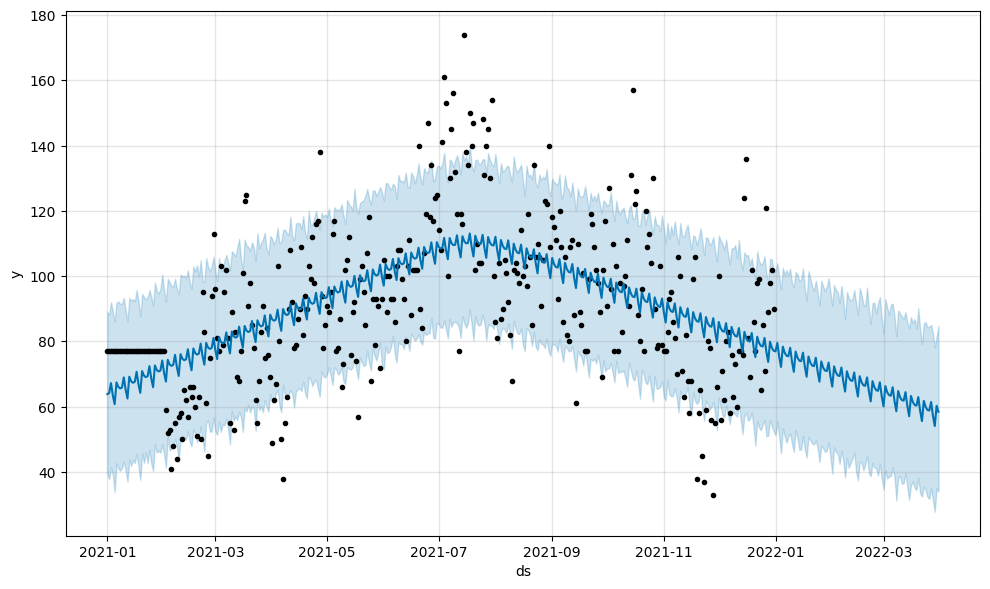

In [283]:
# Membuat plot hasil prediksi
fig1 = m.plot(forecast)

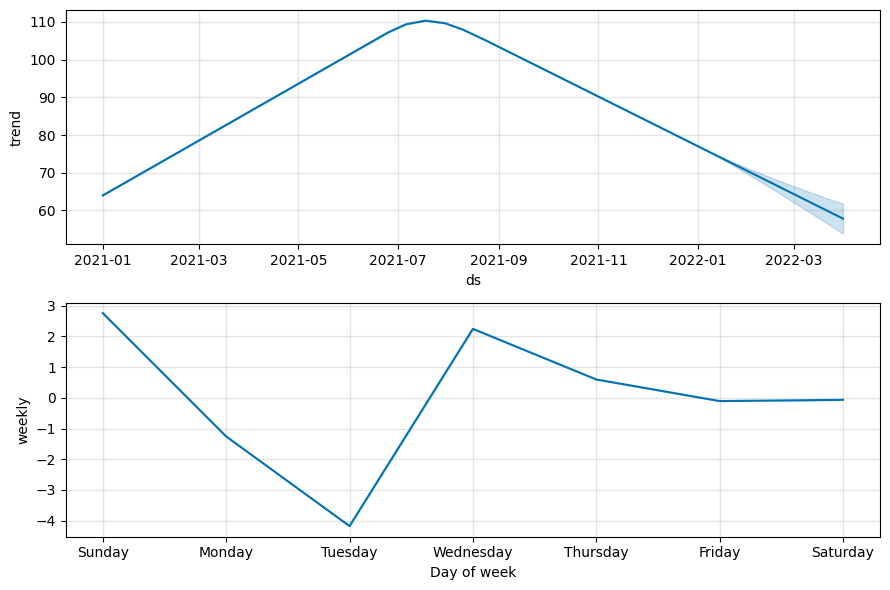

In [284]:
# Membuat plot dengan melihat trend dan weekly
fig2 = m.plot_components(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/9k5ktmlt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/o5gc_5ac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64402', 'data', 'file=/tmp/tmp1lsysle3/9k5ktmlt.json', 'init=/tmp/tmp1lsysle3/o5gc_5ac.json', 'output', 'file=/tmp/tmp1lsysle3/prophet_modelwd_429ie/prophet_model-20231203231332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cut

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/18i879un.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lsysle3/j1t6yef7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65932', 'data', 'file=/tmp/tmp1lsysle3/18i879un.json', 'init=/tmp/tmp1lsysle3/j1t6yef7.json', 'output', 'file=/tmp/tmp1lsysle3/prophet_modelpy7osiqf/prophet_model-20231203231333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


   horizon        mae       rmse         mse      mape     smape
0   9 days   8.201229  11.025259  121.556343  0.100068  0.100622
1  10 days   9.437514  12.935951  167.338824  0.112090  0.114663
2  11 days   9.144557  12.298666  151.257178  0.111785  0.113060
3  12 days  11.178706  15.399530  237.145518  0.128026  0.133353
4  13 days  14.135801  20.543083  422.018274  0.147667  0.159621
..     ...        ...        ...         ...       ...       ...
77 86 days  16.571373  20.890618  436.417923  0.196467  0.220515
78 87 days  15.360559  19.828045  393.151359  0.186471  0.208220
79 88 days  16.394687  20.540553  421.914312  0.202190  0.224113
80 89 days  16.612484  21.147209  447.204434  0.203044  0.225630
81 90 days  16.025368  20.460418  418.628698  0.199688  0.219874

[82 rows x 6 columns]


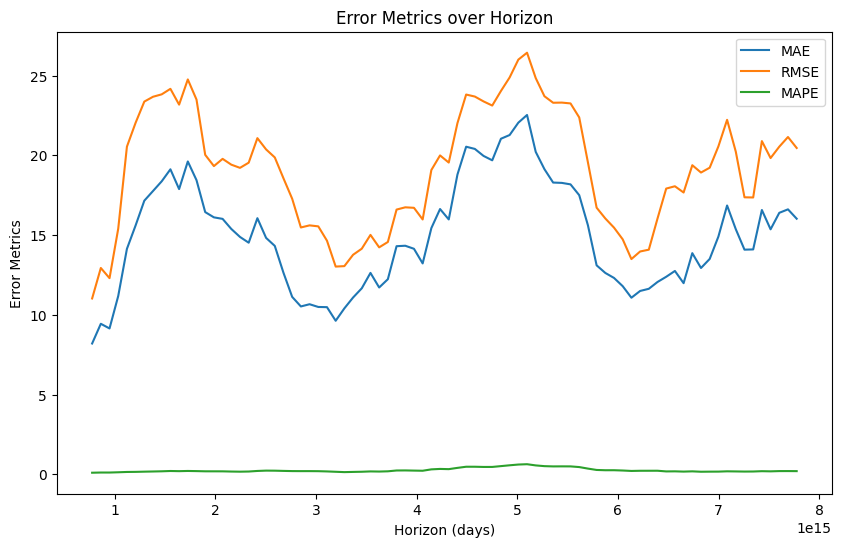

In [285]:
# Inisialisasi dan melatih model Prophet
model = Prophet()
model.fit(df)

# Melakukan cross-validation
df_cv = cross_validation(model, horizon='90 days')  # Cross-validation untuk horizon 90 hari (3 bulan)

# Menghitung metrics performa
df_metrics = performance_metrics(df_cv)

# Menampilkan metrics seperti MAE, RMSE, dan lainnya
print(df_metrics[['horizon', 'mae', 'rmse', 'mse', 'mape', 'smape']])

# Plotting MAE terhadap horizon
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_metrics['horizon'], df_metrics['mae'], label='MAE')
ax.plot(df_metrics['horizon'], df_metrics['rmse'], label='RMSE')
ax.plot(df_metrics['horizon'], df_metrics['mape'], label='MAPE')
ax.set_xlabel('Horizon (days)')
ax.set_ylabel('Error Metrics')
ax.set_title('Error Metrics over Horizon')
ax.legend()
plt.show()

# **Prediksi Tertinggi dari semua Wilayah**



In [286]:
# Misalnya, memiliki dataframe forecast_wilayah_1, forecast_wilayah_2, dst.
forecast_total = pd.concat([df_DKI1, df_DKI2, df_DKI3, df_DKI4, df_DKI5])

In [287]:
# Menemukan baris dengan nilai prediksi tertinggi
row_prediksi_tertinggi = forecast_total.loc[forecast_total['y'].idxmax()]

# Tampilkan hasil
print("Prediksi Tertinggi:")
print(row_prediksi_tertinggi)

Prediksi Tertinggi:
ds              7/15/2021
Kota        Jakarta Timur
pm10                 95.0
y                   174.0
so2                  40.0
co                   15.0
o3                   22.0
no2                  24.0
max                   174
critical             PM25
categori      TIDAK SEHAT
stasiun      Lubang Buaya
Name: 1012, dtype: object


In [288]:
# Memfilter hasil prediksi untuk rentang waktu tertentu (contoh: 3 bulan terakhir)
end_date = forecast['ds'].max()  # Tanggal terakhir dalam hasil prediksi
start_date = end_date - pd.DateOffset(months=3)  # Tanggal 3 bulan sebelumnya

# Memfilter DataFrame untuk rentang waktu tertentu
forecast_range = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

# Mencari nilai tertinggi ('yhat') dalam rentang waktu tersebut
nilai_tertinggi = forecast_range['yhat'].max()

print("Nilai Tertinggi dalam 3 Bulan Terakhir:", nilai_tertinggi)

Nilai Tertinggi dalam 3 Bulan Terakhir: 79.57927855978372


In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ds        1825 non-null   object 
 1   Kota      1825 non-null   object 
 2   pm10      1825 non-null   float64
 3   y         1825 non-null   float64
 4   so2       1825 non-null   float64
 5   co        1825 non-null   float64
 6   o3        1825 non-null   float64
 7   no2       1825 non-null   float64
 8   max       1825 non-null   int64  
 9   critical  1825 non-null   object 
 10  categori  1825 non-null   object 
 11  stasiun   1825 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 171.2+ KB


In [290]:
df.describe()

,pm10,y,so2,co,o3,no2,max
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,52.289863,77.997808,35.051507,11.900274,31.680548,19.632877,77.625205
std,14.346046,22.364823,12.334767,5.052566,14.531023,9.348281,22.612604
min,14.000000,13.000000,2.000000,2.000000,7.000000,1.000000,17.000000
25%,44.000000,64.000000,26.000000,9.000000,22.000000,13.000000,62.000000
50%,53.000000,77.000000,33.000000,11.000000,28.000000,18.000000,77.000000
75%,61.000000,91.000000,43.000000,14.000000,38.000000,25.000000,91.000000
max,179.000000,174.000000,82.000000,47.000000,151.000000,65.000000,179.000000


In [291]:
df = df.rename(columns={'y': 'pm2.5'})

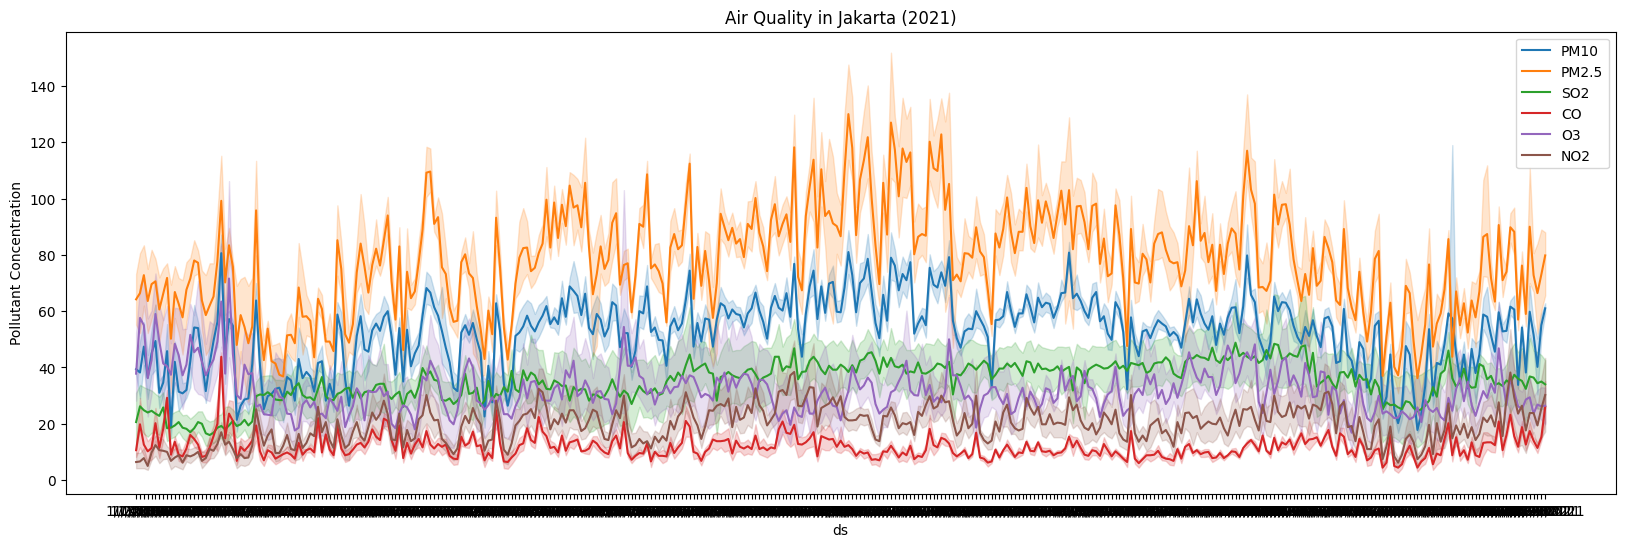

In [292]:
# Visualisasi Data
plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x='ds', y='pm10', label='PM10')
sns.lineplot(data=df, x='ds', y='pm2.5', label='PM2.5')
sns.lineplot(data=df, x='ds', y='so2', label='SO2')
sns.lineplot(data=df, x='ds', y='co', label='CO')
sns.lineplot(data=df, x='ds', y='o3', label='O3')
sns.lineplot(data=df, x='ds', y='no2', label='NO2')
plt.xlabel('ds')
plt.ylabel('Pollutant Concentration')
plt.title('Air Quality in Jakarta (2021)')
plt.legend()
plt.show()